In [1]:
import os
import numpy as np
from PIL import Image

from glob import glob
from tqdm.auto import tqdm

from helper import *

Extraction of classes
We will be classifying images based on US State
This info is contained within the metadata file aquired with the images

The original metadata file is quite large so we will aim to reduce it asap, by only retaining images we are using for this project
The method used is not very fast however, but since it will only be done once for preprocessing it is deemed acceptable

In [2]:
imageList = os.listdir("data")
classes = ['FL', 'CA', 'NM', 'ME']
out_dir = "processed"
images = []

# Notebook Settings
resampleToggle = False
repeatMeta = False

In [3]:
import pandas as pd


if repeatMeta:
    metadata = pd.read_csv("metadata.csv", engine='python')
    metadataShort = pd.DataFrame(columns=metadata.columns)

    for i in tqdm(imageList):
        relMeta = metadata.loc[metadata['NAIP Entity ID'].str.contains(i[:15], case=False)].drop_duplicates(subset=['State'], keep='last')
        relMeta = relMeta.loc[relMeta['State'].isin(classes)]   #Check if acceptable class
        metadataShort = metadataShort.append(relMeta, ignore_index = True)   #For record

    metadataShort.to_csv("metadataShort.csv")
    del metadata, relMeta  #To clear up memory 

else:
    metadataShort = pd.read_csv("metadataShort.csv", engine='python')


idAll = metadataShort["NAIP Entity ID"]
labelAll = metadataShort["State"]

## FOR RUTURE CREATE PRE-SPLIT BASED ON ROOT IMAGE (to avoid giving the ai "learned images")
## Would only need it for the final Test set, the training & Validation data should be ok... but could be splt too

from sklearn.model_selection import train_test_split

id_vali, id_test, lab_vali, lab_test = train_test_split(idAll, labelAll, stratify=labelAll, test_size=0.15)



In [4]:
metadataShort.head()

,Unnamed: 0,NAIP Entity ID,State,Agency,Vendor,Map Projection,Projection Zone,Datum,Resolution,Units,...,NW Corner Lat dec,NW Corner Long dec,NE Corner Lat dec,NE Corner Long dec,SE Corner Lat dec,SE Corner Long dec,SW Corner Lat dec,SW Corner Long dec,Display ID,Entity ID
0,0,M_2608003_NE_17_060_20191215,FL,USDA,USDA_FSA_APFO,UTM,17N,NAD83,0.6,METER,...,27.001975,-80.689539,27.001814,-80.622775,26.935508,-80.622997,26.935669,-80.689719,M_2608003_NE_17_060_20191215,2855534
1,1,M_2608003_NW_17_060_20191215,FL,USDA,USDA_FSA_APFO,UTM,17N,NAD83,0.6,METER,...,27.001936,-80.752011,27.001805,-80.685305,26.935553,-80.685492,26.935686,-80.752156,M_2608003_NW_17_060_20191215,2855535
2,2,M_2608004_NE_17_060_20191215,FL,USDA,USDA_FSA_APFO,UTM,17N,NAD83,0.6,METER,...,27.002025,-80.564536,27.001803,-80.497714,26.935444,-80.498008,26.935667,-80.564792,M_2608004_NE_17_060_20191215,2855538
3,3,M_2608004_NW_17_060_20191215,FL,USDA,USDA_FSA_APFO,UTM,17N,NAD83,0.6,METER,...,27.001986,-80.627008,27.001794,-80.560244,26.935489,-80.560503,26.935683,-80.627225,M_2608004_NW_17_060_20191215,2855539
4,4,M_2608005_NE_17_060_20191215,FL,USDA,USDA_FSA_APFO,UTM,17N,NAD83,0.6,METER,...,27.002069,-80.439536,27.001789,-80.372594,26.935430,-80.372961,26.935714,-80.439864,M_2608005_NE_17_060_20191215,2855542


In [5]:
from sample import sample_images


if resampleToggle:
    for c,img in enumerate(tqdm(imageList)):
        try:
            
            #image = extractImage("data/",img,"dataHuman/")
            image = extractImage("data/",img)
            samples,corners = sample_images([image], 20, [128,128,4], 20)
            if c in id_test.index:
                tT = "test"
            else:
                tT = "train"
            for i, (sample, corner) in enumerate(zip(samples, corners)):
                    export_name = f"{labelAll[c]}_{c}_{i}"
                    h5_file = h5py.File(f"{out_dir}/{tT}/{export_name}.h5", "w-")
                    dset = h5_file.create_dataset("IMG", sample[0].shape, compression="gzip")
                    dset[...] = sample[0]
                    dset.attrs["x"] = corner[0]
                    dset.attrs["y"] = corner[1]
                    dset.attrs["z"] = corner[2]
                    h5_file.close()
        except:
            pass

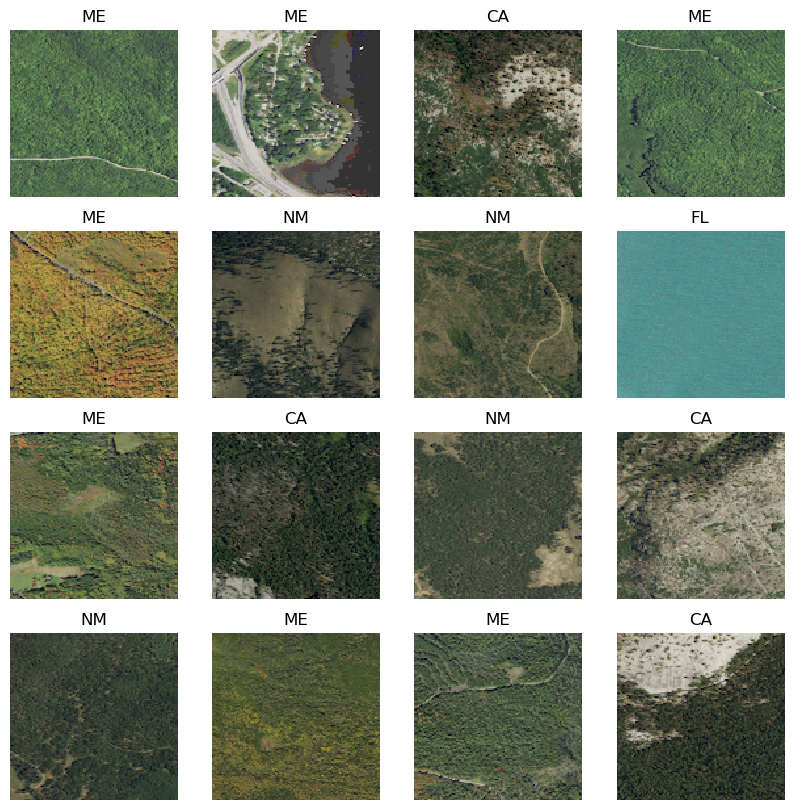

In [6]:
import matplotlib.pyplot as plt
from numpy.random import randint

sampleList = os.listdir("processed/train/")

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)

    sel = sampleList[randint(0, len(sampleList))]
    img = load_sample("processed/train/" + sel)
    img = imgRGBConverter(img)

    plt.imshow(img.astype("uint8"))
    plt.title(str(sel[:2]))
    plt.axis("off")
plt.show()

In [7]:
## LOAD DATA FOR SPLITTING

#Training and validation come from the same sampled images 
img_train, lab_train = sampleLoader("processed/train/",classes)
img_train, img_vali, lab_train, lab_vali = train_test_split(img_train, lab_train, stratify=lab_train, test_size=0.3)

#Testing images are specificaly ones that have never been sampled
#Therefore it checks the generality of the network
img_test, lab_test = sampleLoader("processed/test/",classes)


  0%|          | 0/3336 [00:00<?, ?it/s]


NameError: name 'classes' is not defined

In [ ]:
## START UP TF CUDA
import tensorflow as tf 

gpus = tf.config.list_physical_devices('GPU')
assert len(gpus) > 0
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

In [ ]:
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((img_train, lab_train)).batch(batch_size).shuffle(len(img_train), reshuffle_each_iteration=True).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((img_vali, lab_vali)).batch(batch_size).shuffle(len(img_vali), reshuffle_each_iteration=True)


In [ ]:
from tensorflow.keras import layers, Sequential

num_classes = len(classes)
img_height = 128
img_width = 128

data_augmentation = Sequential(
  [
  layers.RandomFlip(), 
  layers.RandomRotation(0.1), 
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 4)),
  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=200
history = model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import random
randomlist = random.sample(range(0, len(img_test)), 5)

cor = 0
for i in range(0,len(img_test)):

    img_array = tf.expand_dims(img_test[i], 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    if np.argmax(score) == lab_test[i]:
        cor += 1 

    if i in randomlist:
        print(
            "This image from class: {}, most likely belongs to {} with a {:.2f} percent confidence."
            .format(classes[lab_test[i]],classes[np.argmax(score)], 100 * np.max(score))
        )

        plt.figure(figsize=(5, 5))
        img = imgRGBConverter(img_test[i])
        plt.imshow(img.astype("uint8"))
        plt.title("Class: {}, Predicted {} with {:.2f} confidence."
                .format(classes[lab_test[i]],classes[np.argmax(score)], 100 * np.max(score)))
        plt.axis("off")
        plt.show()

print("Unseen Test Set accuracy: {}".format(cor/len(img_test)*100))
